In [35]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from skimage.io import imread
from google.colab import drive
import math

In [36]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define the function to compute the kernel given the weights and the degree of the polynomial

In [37]:
def compute_2D_LPA_kernel(w, N):
    # compute the 2D LPA kernel for a given weights and polynomial degree
    # input:
    #   w: matrix containing the weights for the local LS problem
    #   N: degree of the polynomial approximation
    # return:
    #   g: the computed LPA kernel


    # window size is the lenght of the weight vector
    r, c = w.shape
    M = r*c

    # create the matrix T
    tx = np.linspace(0, 1, c)
    ty = np.linspace(0, 1, r)
    tx, ty = np.meshgrid(tx, ty)
    tx = tx.reshape(-1)
    ty = ty.reshape(-1)
    T = np.zeros((M,(N+1)**2))
    cnt = 0
    for i in range(N+1):
        for j in range(N-i+1):
            if i==0 and j==0:
                T[:, cnt] = np.ones(M)
            else:
                T[:, cnt] = tx**i * ty**j
            cnt = cnt + 1
    T = T[:, :cnt]

    # unroll the matrix of the weights
    w = w.flatten()

    # generate the inverse of weights
    winv = np.zeros_like(w)
    winv[w!=0] = 1/w[w!=0]

    # define the weight matrix
    W = np.diag(w)
    Winv = np.diag(winv)

    ## construct the LPA kernel

    # compute the qr decomposition of WT
    Q, R = np.linalg.qr(W@T, mode = 'reduced')

    #  define Qtilde
    Qtilde = Winv @ Q

    # adjust Qtilde with the  weights matrix squared.
    W2Qtilde = W**2 @ Qtilde

    # select the central row of W2Qtilde
    row = W2Qtilde[W2Qtilde.shape[0]//2,:]

    # compute the kernel
    g_bar = np.zeros(M)
    for i in range(min(N+1,M)):
      g_bar = g_bar + row[i]*W2Qtilde[:,i]


    #reshape the kernel in a matrix
    g_bar = g_bar.reshape((r,c))

    # flipping, since it is used in convolution
    g = np.flip(g_bar)

    return g


Load the image and add the noise

In [38]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255

sigma_noise = 20/255
noisy_img = img + np.random.normal(size=img.shape) * sigma_noise

psnr_noisy = 10*np.log10(1/(((img-noisy_img)**2).mean()))


Text(0.5, 1.0, 'Noisy image, PSNR = 22.14')

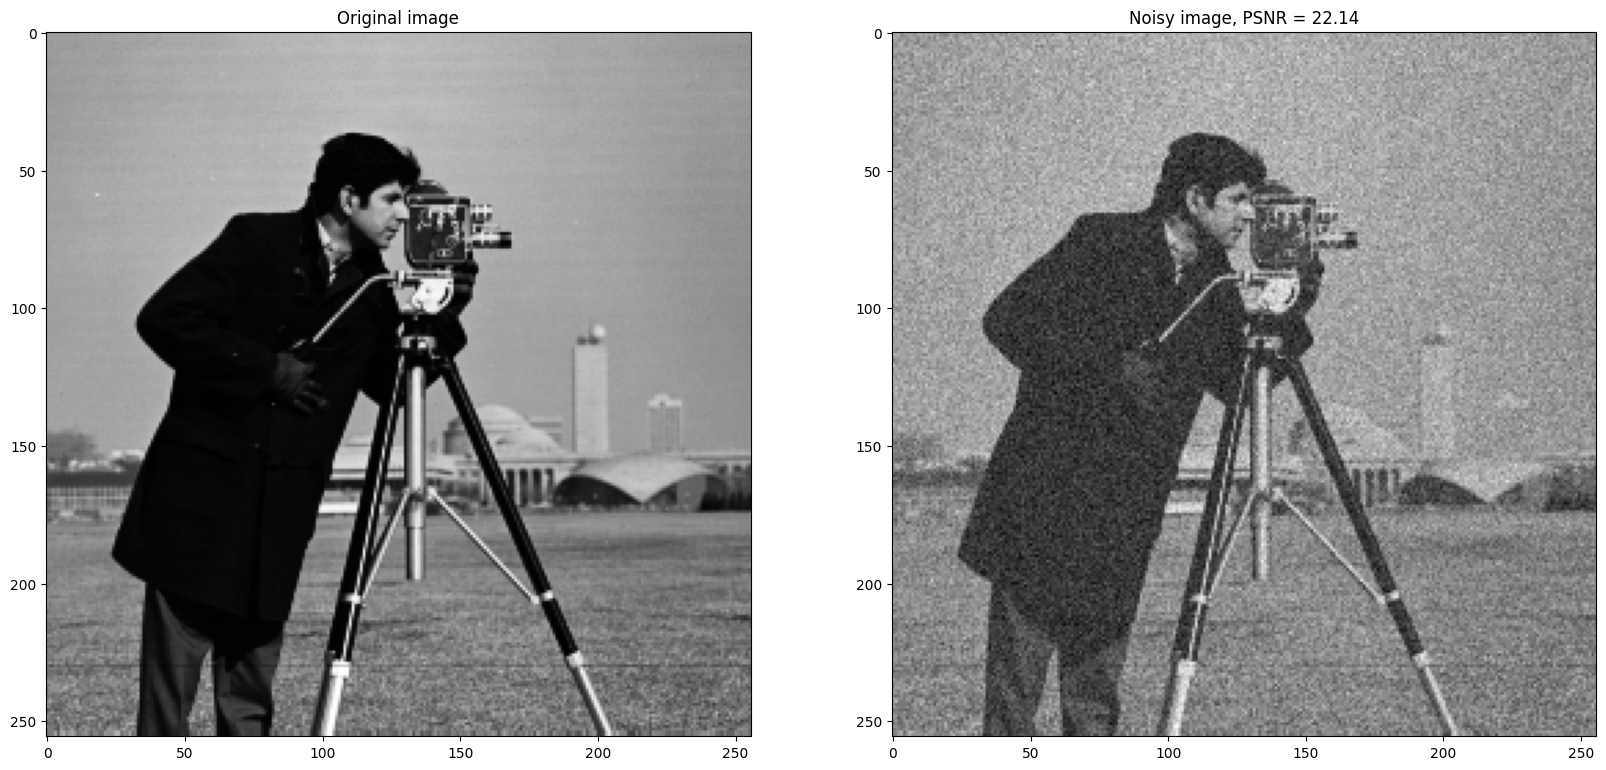

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

LPA-ICI 2D
----------
Set the LPA-ICI parameters

In [40]:
# maximum degree of polynomial used for fitting
N = 1

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 21
all_h = np.arange(1, hmax+1)

Generate the LPA kernels for all the scale. Use centered weights.


In [41]:
all_g = []
for i, h in enumerate(all_h):
        # define the weights for the scale h symmetric

        # size of the weight MATRIX
        w = np.ones((2*h -1, 2*h -1))
        #w = w/np.linalg.norm(w, 2);

        # compute and store the kernel g
        g = compute_2D_LPA_kernel(w, N)
        all_g.append(g)

Initialize all the variables for the ICI rule

In [42]:
# initialize the estimate for each scale
yhat = np.zeros((img.shape))

# initialize the vector containing the best scale for each sample
best_scale = np.zeros(shape=yhat.shape)

# initialize the lower and upper bound matrices
lower_bounds = - np.inf * np.ones(shape=yhat.shape)
upper_bounds = np.inf * np.ones(shape=yhat.shape)

Loop over all the scales

In [43]:
for i, h in enumerate(all_h):
    g = all_g[i]

    # compute the estimate for the scale h
    yhat_h = convolve2d(noisy_img,g, mode='same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma * sigma_noise * np.linalg.norm(g, ord=2)
    ub = yhat_h + Gamma * sigma_noise * np.linalg.norm(g, ord=2)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    # update best_scale
    idx = np.where(upper_bounds>lower_bounds)
    yhat[idx] = yhat_h[idx]

    idx = np.where((lower_bounds>upper_bounds) * (best_scale==0))
    if (len(idx)>0):
      best_scale[idx] = h-1

Compute the PSNR

In [44]:
psnr = 10*np.log10(1 / np.mean((img - yhat) ** 2))

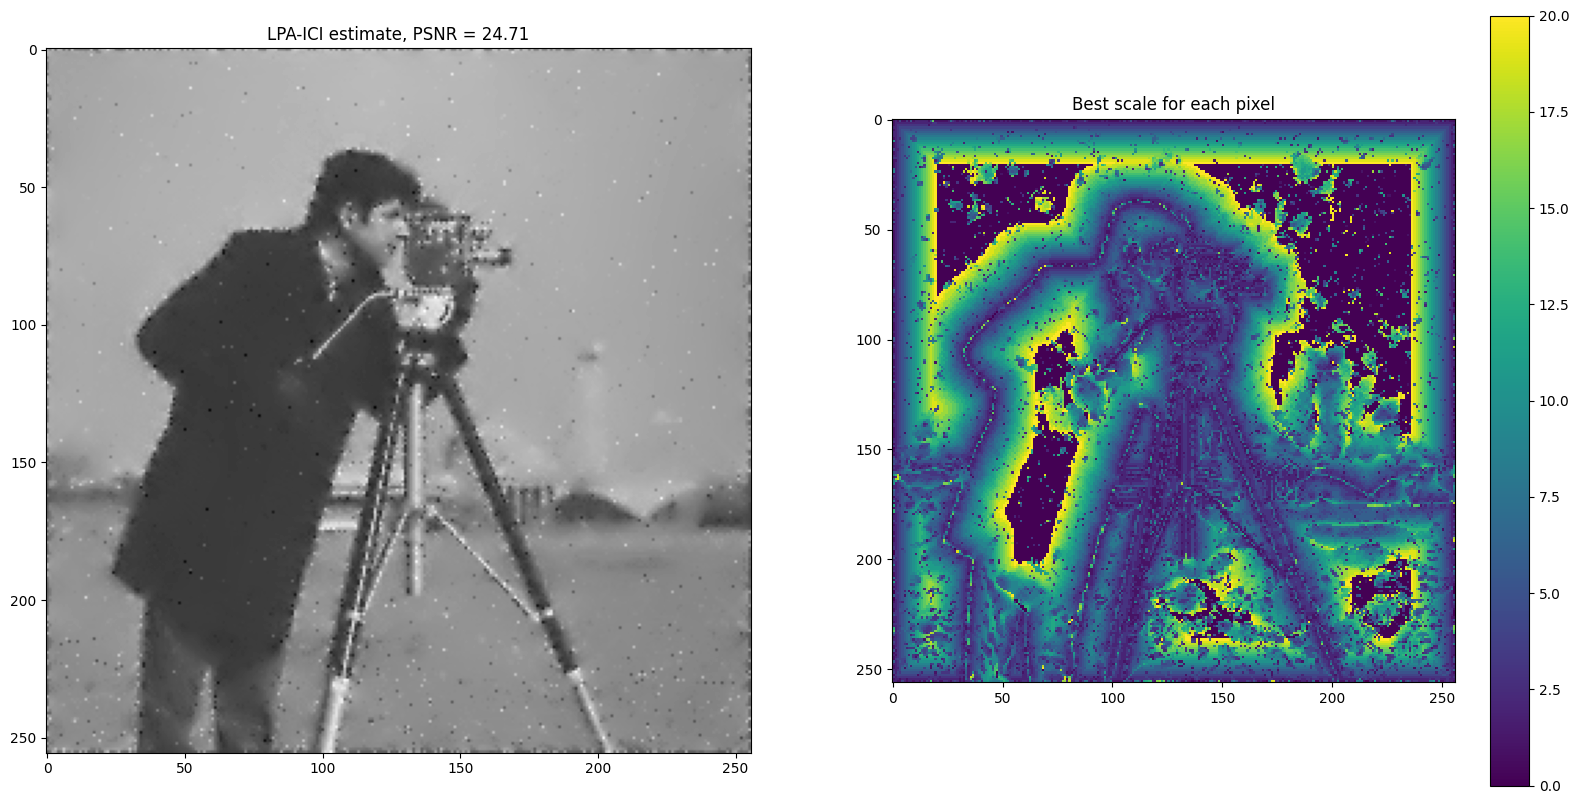

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(yhat, cmap='gray')
ax[0].set_title(f'LPA-ICI estimate, PSNR = {psnr:.2f}')

ax[1].imshow(best_scale)
ax[1].set_title('Best scale for each pixel')
fig.colorbar(ax[1].pcolormesh(best_scale), ax=ax[1])

Anisotropic LPA-ICI
------------------------
Set the parameters


In [46]:
# maximum degree of polynomial used for fitting
N = 1

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 21
all_h = np.arange(1, hmax+1)

# set all the direction values
all_theta = np.arange(4)

Generate the LPA kernels for all the scales and all the directions

In [47]:
all_g = []

for theta in all_theta:
    all_g_theta = []
    for i, h in enumerate(all_h):
        # define the weights for the scale h and the direction theta
        w = np.zeros((2*h-1,2*h-1))
        a = math.floor((2*h-1)/2)
        b = math.ceil((2*h-1)/2)
        if theta == 1:
            w[:,a:] = 1
            w[b:,:] = 0
        elif theta == 2:
            w[:,:b] = 1
            w[b:,:] = 0
        elif theta == 3:
            w[:,:b] = 1
            w[:a,:] = 0
        elif theta == 4:
            w[:,a:] = 1
            w[:a,:] = 0

        # compute and store the kernel g
        g = compute_2D_LPA_kernel(w, N)

        all_g_theta.append(g)

    all_g.append(all_g_theta)


Initialize all the variables

In [48]:
# initialize the estimate for each scale
yhat = np.zeros(img.shape)

# initialize the matrix of the aggregation weights
weights = np.zeros(img.shape)


Use the LPA-ICI to compute find the best scale for each direction and compute the finale estimates

In [49]:
# loop over all the directions
for theta in all_theta:
    # initialize the estimate for the direction theta
    yhat_theta = np.zeros(img.shape)

    # initialize the matrix all the variances for the direction theta
    var_theta = np.zeros(img.shape)

    # initialize the lower and upper bounds matrices
    lower_bounds = - np.inf * np.ones(shape=yhat.shape)
    upper_bounds = np.inf * np.ones(shape=yhat.shape)

    # loop over all scales
    all_g_theta = all_g[theta]
    for i, h in enumerate(all_h):
        g = all_g_theta[i]

        # compute the estimate for the scale h
        yhat_h = convolve2d(noisy_img,g, mode='same')

        # compute the lower and upper bound of the confidence interval for the scale h
        lb = yhat_h - Gamma * sigma_noise * np.linalg.norm(g, ord=2)
        ub = yhat_h + Gamma * sigma_noise * np.linalg.norm(g, ord=2)

        # update the lower and upper bounds
        lower_bounds = np.maximum(lower_bounds, lb)
        upper_bounds = np.minimum(upper_bounds, ub)

        # update the estimate
        # update yhat_theta
        idx = np.where(upper_bounds>lower_bounds)
        yhat_theta[idx] = yhat_h[idx]

        # update the matrix with the variances
        # update var_theta (already at the denominator)
        var_theta[idx] = 1/(sigma_noise * np.linalg.norm(g,2))**2

    # update the estimates and the weights
    # numerator of aggregation step
    yhat = yhat + var_theta * yhat_theta
    # denominator of aggregation step
    weights = weights + var_theta

# compute the final estimates
yhat = yhat / weights

<ipython-input-49-e180eb1fa1bd>:36: RuntimeWarning: divide by zero encountered in double_scalars
  var_theta[idx] = 1/(sigma_noise * np.linalg.norm(g,2))**2


Compute the PSNR

In [50]:
psnr = 10*np.log10(1 / np.mean((img - yhat) ** 2))

Text(0.5, 1.0, 'LPA-ICI estimate, PSNR = 26.56')

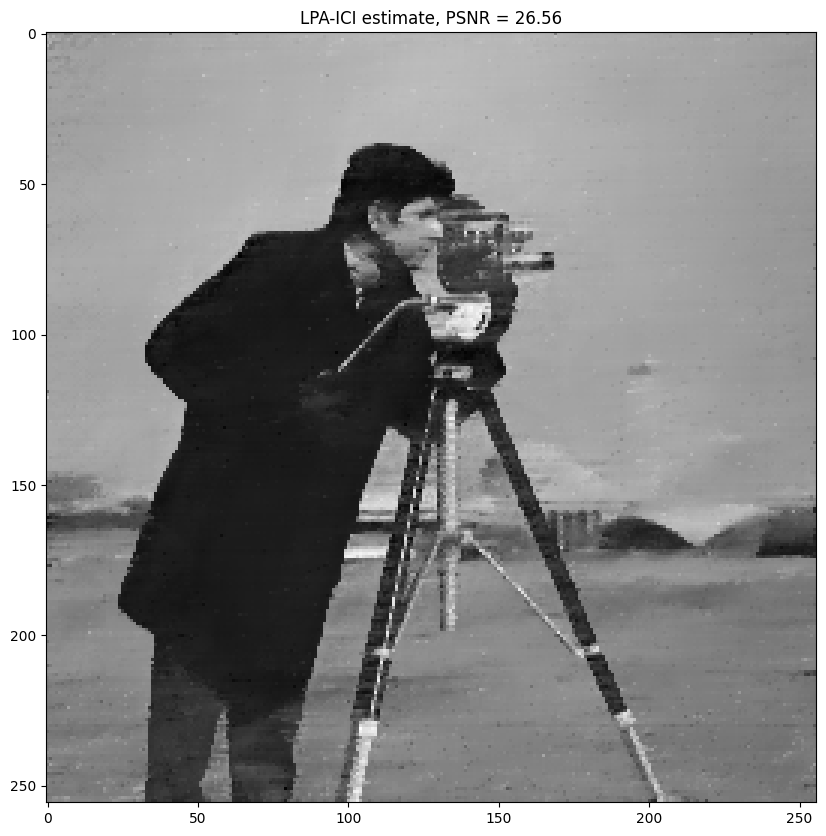

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(yhat, cmap='gray')
plt.title(f'LPA-ICI estimate, PSNR = {psnr:.2f}')
